data：  

GIS文件：
1.深圳行政区划  

数据：
1.出租车OD数据

### 1.读取shp文件

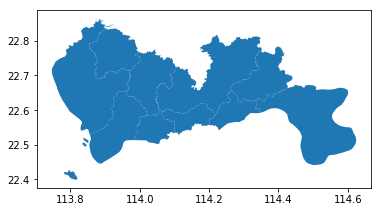

In [1]:
#导入必要的包
import pandas as pd
import numpy as np

#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas包
import geopandas

#shapely包
from shapely.geometry import Point,Polygon,shape

#读取shapefile文件
shp = r'shapefile/sz.shp'
sz = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#绘制看看长什么样
sz.plot()

In [2]:
type(sz)

geopandas.geodataframe.GeoDataFrame

geopandas的格式，就是类似pandas的表格，但是加上一列geometry，记录了每行记录的地理信息  
每行记录的geometry，它的格式是shapely包的Polygon

In [3]:
sz.head(5)

,centroid_x,centroid_y,qh,geometry
0,114.143157,22.577605,罗湖,"POLYGON ((114.10006 22.53431, 114.09969 22.535..."
1,114.041535,22.546180,福田,"POLYGON ((113.98578 22.51348, 113.98558 22.523..."
2,114.270206,22.596432,盐田,"POLYGON ((114.22772 22.54290, 114.22643 22.543..."
3,113.851387,22.679120,宝安,"MULTIPOLYGON (((113.81831 22.54676, 113.81816 ..."
4,113.926290,22.766157,光明,"POLYGON ((113.98587 22.80304, 113.98605 22.802..."


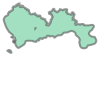

In [4]:
#用unary_union可以将一个geopandas的所有记录合并为一个图形，合并出来的结果是Polygon
sz.unary_union

### 2.栅格化
我们需要写一个代码，能够直接批量算出来一批经纬度的栅格编号


In [5]:
#栅格化代码
import math
#定义一个测试栅格划的经纬度
testlon = 114
testlat = 22.5

#划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#定义栅格大小(单位m)
accuracy = 500;

#计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

#计算栅格的经纬度编号
LONCOL=divmod(float(testlon) - (lonStart - deltaLon / 2) , deltaLon)[0]
LATCOL=divmod(float(testlat) - (latStart - deltaLat / 2) , deltaLat)[0]

#计算栅格的中心点经纬度
HBLON = LONCOL*deltaLon + (lonStart - deltaLon / 2)#格子编号*格子宽+起始横坐标-半个格子宽=格子中心横坐标
HBLAT = LATCOL*deltaLat + (latStart - deltaLat / 2)

#把算好的东西print出来看看
LONCOL,LATCOL,HBLON,HBLAT,deltaLon,deltaLat

(51.0,
 12.0,
 113.99800701150498,
 22.499547959873865,
 0.004872614089207591,
 0.004496605206422906)

另外，此处LONCOL、LATCOL的计算，我希望起点在第一个格子的中心，因此我减去半个栅格，你也可以希望起点在第一个格子的顶点，但是我们后面的结果没有什么大区别。此处没必要纠结，因为你生成了栅格，后面还是要筛掉只保留在shp范围内的格子。而我们的初始边界栅格，应该放在shp边界外，也就是说你在纠结的第一个格子在哪没意义，最后还是会把你第一个格子剔除掉。

另外，我们要生成这些栅格的geopandas数据

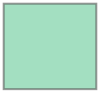

In [6]:
from shapely.geometry import Point,Polygon,shape
Polygon([(HBLON+deltaLon/2,HBLAT-deltaLat/2),
        (HBLON+deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT-deltaLat/2)])

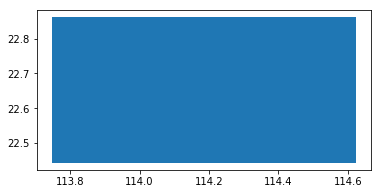

In [7]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point,Polygon,shape


#定义空的geopandas表
data = geopandas.GeoDataFrame()

#定义空的list，后面循环一次就往里面加东西
LONCOL = []
LATCOL = []
geometry = []
HBLON1 = []
HBLAT1 = []

#计算总共要生成多少个栅格
#lon方向是lonsnum个栅格
lonsnum = int((lon2-lon1)/deltaLon)+1
#lat方向是latsnum个栅格
latsnum = int((lat2-lat1)/deltaLat)+1

for i in range(lonsnum):
    for j in range(latsnum):

        HBLON = i*deltaLon + (lonStart - deltaLon / 2)
        HBLAT = j*deltaLat + (latStart - deltaLat / 2)
        #把生成的数据都加入到前面定义的空list里面
        LONCOL.append(i)
        LATCOL.append(j)
        HBLON1.append(HBLON)
        HBLAT1.append(HBLAT)
        
        #生成栅格的Polygon形状
        #这里我们用周围的栅格推算三个顶点的位置，否则生成的栅格因为小数点取值的问题会出现小缝，无法完美覆盖
        HBLON_1 = (i+1)*deltaLon + (lonStart - deltaLon / 2)
        HBLAT_1 = (j+1)*deltaLat + (latStart - deltaLat / 2)
        geometry.append(Polygon([
        (HBLON-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT_1-deltaLat/2),
        (HBLON-deltaLon/2,HBLAT_1-deltaLat/2)]))
        
#为geopandas文件的每一列赋值为刚刚的list
data['LONCOL'] = LONCOL
data['LATCOL'] = LATCOL
data['HBLON'] = HBLON1
data['HBLAT'] = HBLAT1
data['geometry'] = geometry

data.plot()

In [8]:
data.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,0,113.749504,22.445589,"POLYGON ((113.74707 22.44334, 113.75194 22.443..."
1,0,1,113.749504,22.450085,"POLYGON ((113.74707 22.44784, 113.75194 22.447..."
2,0,2,113.749504,22.454582,"POLYGON ((113.74707 22.45233, 113.75194 22.452..."
3,0,3,113.749504,22.459079,"POLYGON ((113.74707 22.45683, 113.75194 22.456..."
4,0,4,113.749504,22.463575,"POLYGON ((113.74707 22.46133, 113.75194 22.461..."


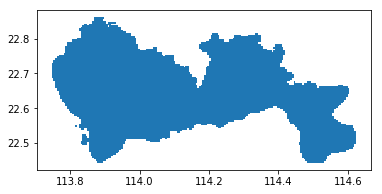

In [9]:
#取栅格和深圳行政区划的交集栅格
grid = data[data.intersects(sz.unary_union)]
grid.plot()

### 3.将数据对应到栅格
提示：我们上一步已经把testlon和testlat实现了栅格化，那么如何让出租车的OD数据全部都栅格化呢？（请不要用到循环语句，循环遍历计算效率非常低）

In [10]:
import pandas as pd
TaxiOD = pd.read_csv(r'data-sample/TaxiOD.csv')
TaxiOD.columns = ['VehicleNum', 'Stime', 'SLng', 'SLat', 
       'ELng', 'ELat','Etime']
TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17


In [11]:
TaxiOD = TaxiOD[-TaxiOD['ELng'].isnull()].copy()
#计算起点栅格的经纬度编号
TaxiOD['SLONCOL'] = ((TaxiOD['SLng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['SLATCOL'] = ((TaxiOD['SLat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')

#计算起点栅格的中心点经纬度
TaxiOD['SHBLON'] = TaxiOD['SLONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['SHBLAT'] = TaxiOD['SLATCOL']*deltaLat + (latStart - deltaLat / 2)

#计算终点栅格的经纬度编号
TaxiOD['ELONCOL'] = ((TaxiOD['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['ELATCOL'] = ((TaxiOD['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')

#计算终点栅格的中心点经纬度
TaxiOD['EHBLON'] = TaxiOD['ELONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['EHBLAT'] = TaxiOD['ELATCOL']*deltaLat + (latStart - deltaLat / 2)

#筛选去掉起点终点在同一个格子里的OD
TaxiOD = TaxiOD[-((TaxiOD['SLONCOL']==TaxiOD['ELONCOL'])&(TaxiOD['SLATCOL']==TaxiOD['ELATCOL']))]
#筛选去掉不在研究范围内的栅格
TaxiOD = TaxiOD[(TaxiOD['SLONCOL']>=0) & (TaxiOD['SLATCOL']>=0) &(TaxiOD['ELONCOL']>=0) & (TaxiOD['ELATCOL']>=0)&
(TaxiOD['SLONCOL']<=lonsnum) & (TaxiOD['SLATCOL']<=latsnum) &(TaxiOD['ELONCOL']<=lonsnum) & (TaxiOD['ELATCOL']<=latsnum)]

TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime,SLONCOL,SLATCOL,SHBLON,SHBLAT,ELONCOL,ELATCOL,EHBLON,EHBLAT
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48,85,25,114.163676,22.558004,97,23,114.222147,22.549011
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19,98,24,114.227020,22.553507,98,25,114.227020,22.558004
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06,98,25,114.227020,22.558004,103,32,114.251383,22.589480
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42,100,26,114.236765,22.562500,76,26,114.119822,22.562500
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17,79,28,114.134440,22.571494,85,36,114.163676,22.607466


### 4.集计栅格OD（全天、高峰时段）


In [12]:
#集计OD,用df.groupby().count()计数
#这个是对每一列都计数了，所以取其中一列出来，例如我这里取了['VehicleNum']
OD= TaxiOD.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['VehicleNum'].count().reset_index()
#groupby的列都会变成index，所以我们用.reset_index()，将index重新变成列

#OD按大小排序
OD = OD.sort_values(by = 'VehicleNum',ascending = False)
OD.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum
113365,63,17,65,16,298
155022,75,21,74,19,275
113808,63,18,65,16,235
160281,76,21,74,19,173
122609,65,17,63,18,172


### 5.绘制栅格的OD图
#### 5.1 绘制前20的OD

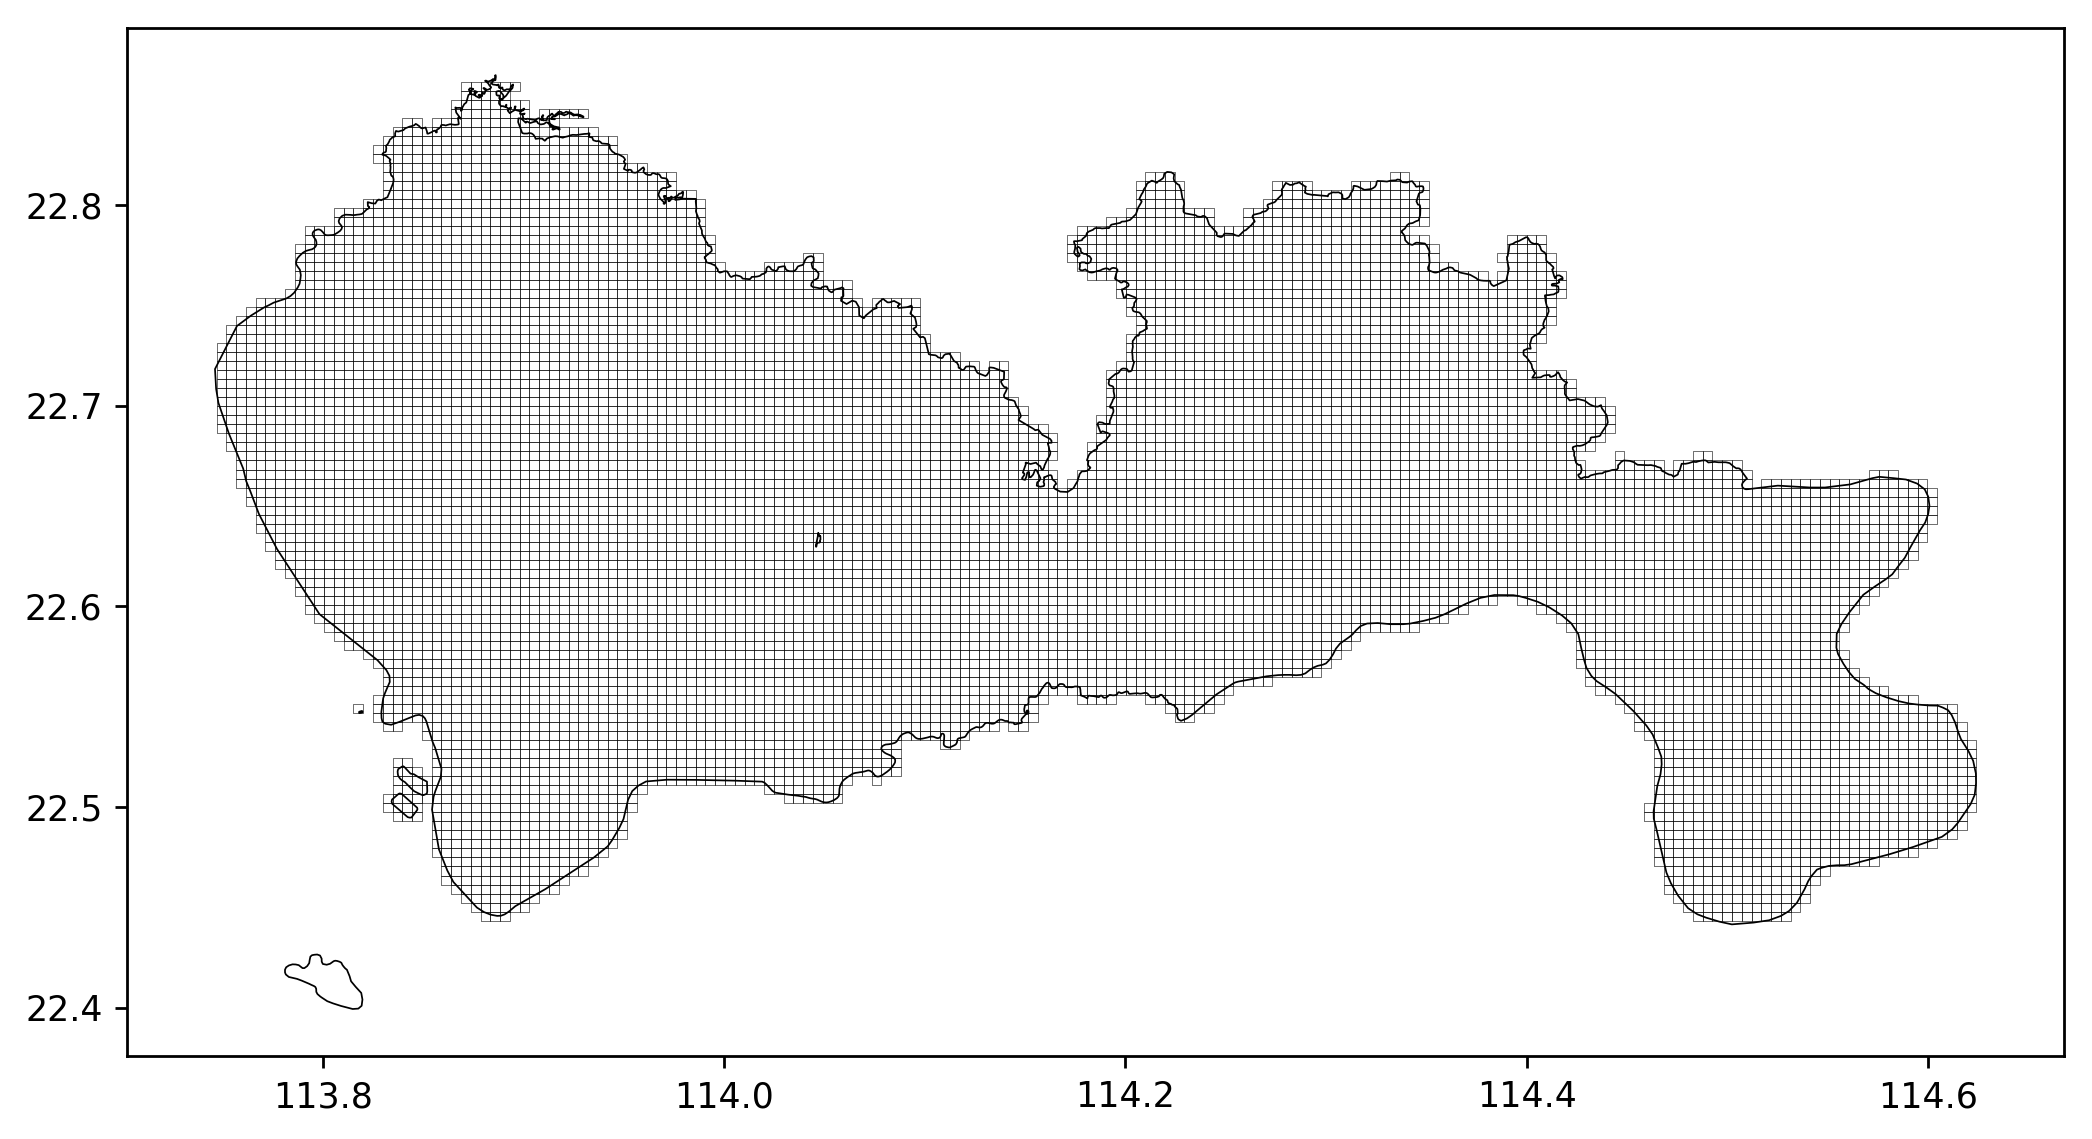

In [13]:
#取前20的OD
Topod = OD.iloc[:20].copy()

#计算起点栅格的中心点经纬度
Topod['SHBLON'] = Topod['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['SHBLAT'] = Topod['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)

#计算终点栅格的中心点经纬度
Topod['EHBLON'] = Topod['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['EHBLAT'] = Topod['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

#导入绘图包
import matplotlib as mpl
import matplotlib.pyplot as plt

fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#把刚才生成的栅格在ax上绘制
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#把合并的行政区划变成一个geopandas，在ax上绘制
SZ_all = geopandas.GeoDataFrame()
SZ_all['geometry'] = [sz.unary_union]
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

plt.show()

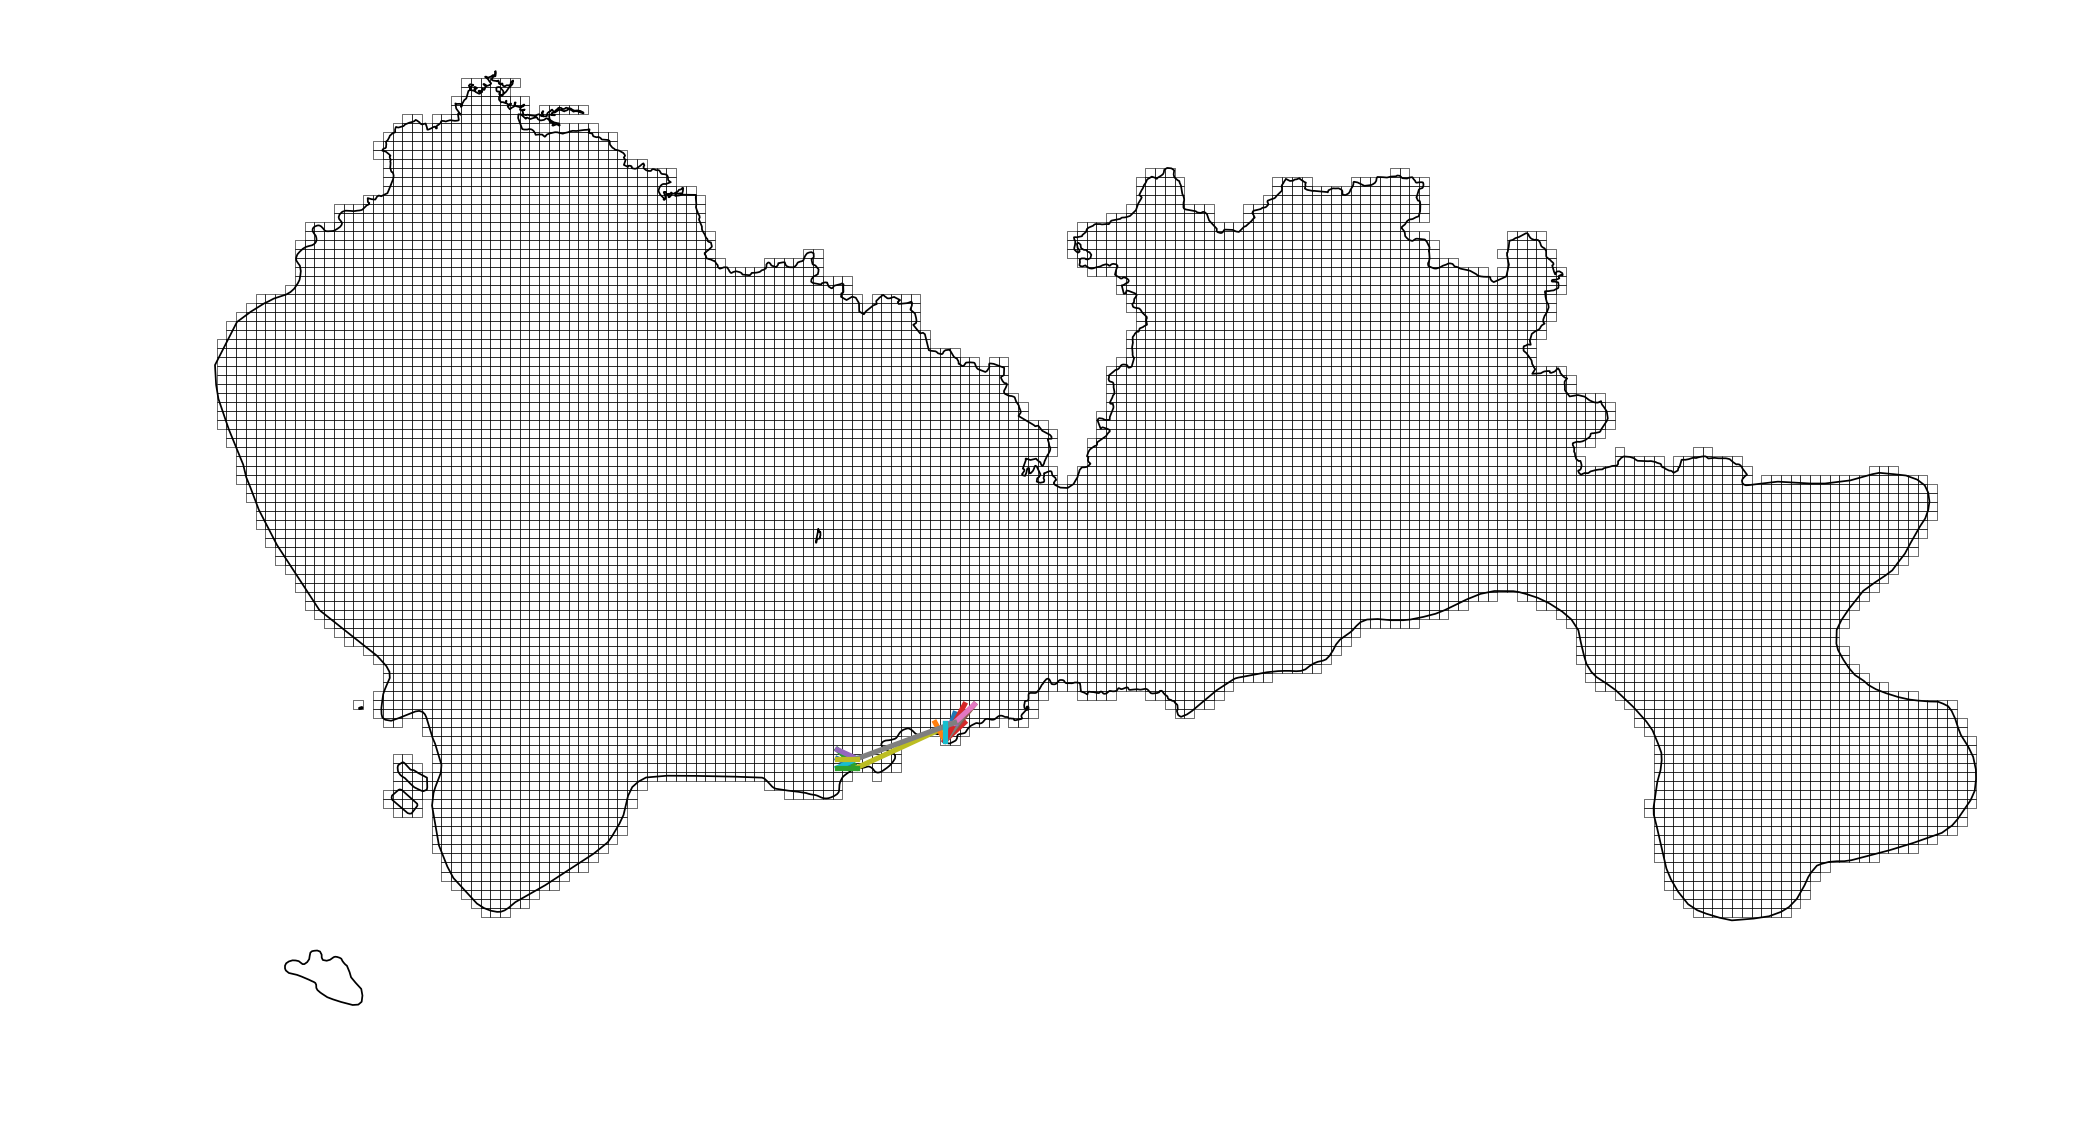

In [14]:
fig  = plt.figure(1,(10,8),dpi = 250)    
ax  = plt.subplot(111)
plt.sca(ax)

#把刚才生成的栅格在ax上绘制
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#绘制整个深圳的范围
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

for i in range(len(Topod)):
    #首先获取OD的经纬度
    #然后用plt.plot()绘制,设定linewidth和color都为固定值
    plt.plot([Topod['SHBLON'].iloc[i],Topod['EHBLON'].iloc[i]],[Topod['SHBLAT'].iloc[i],Topod['EHBLAT'].iloc[i]])


#不显示坐标轴
plt.axis('off')

plt.show()

#### 5.2绘制全部的OD
我们还是把多一点OD画出来吧，这个时候我们要用OD的粗细，颜色深度，和透明度，来表示OD量大小

In [15]:
OD1 = OD[OD['VehicleNum']>10].copy()

#OD从小到大排序方便我们后续操作，因为我们希望小的OD先画，放在最底下，大的OD后画，放在最上面
OD1 = OD1.sort_values(by = 'VehicleNum')

#计算起点栅格的中心点经纬度
OD1['SHBLON'] = OD1['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['SHBLAT'] = OD1['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)

#计算终点栅格的中心点经纬度
OD1['EHBLON'] = OD1['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['EHBLAT'] = OD1['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

#对OD分5组，生成一个取值为0-1的列，每组的值相同，用以表示OD的粗细，取名linewidth
step = 5
OD1['linewidth'] = (np.array(range(len(OD1)))*step/len(OD1)).astype('int')/step+0.1
OD1.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,SHBLON,SHBLAT,EHBLON,EHBLAT,linewidth
41465,37,17,34,21,11,113.929790,22.522031,113.915173,22.540017,0.1
93970,59,27,61,20,11,114.036988,22.566997,114.046733,22.535521,0.1
149728,74,20,76,27,11,114.110077,22.535521,114.119822,22.566997,0.1
38433,36,18,37,18,11,113.924918,22.526528,113.929790,22.526528,0.1
138355,71,23,68,23,11,114.095459,22.549011,114.080841,22.549011,0.1


绘制OD用时 18.980950593948364 秒


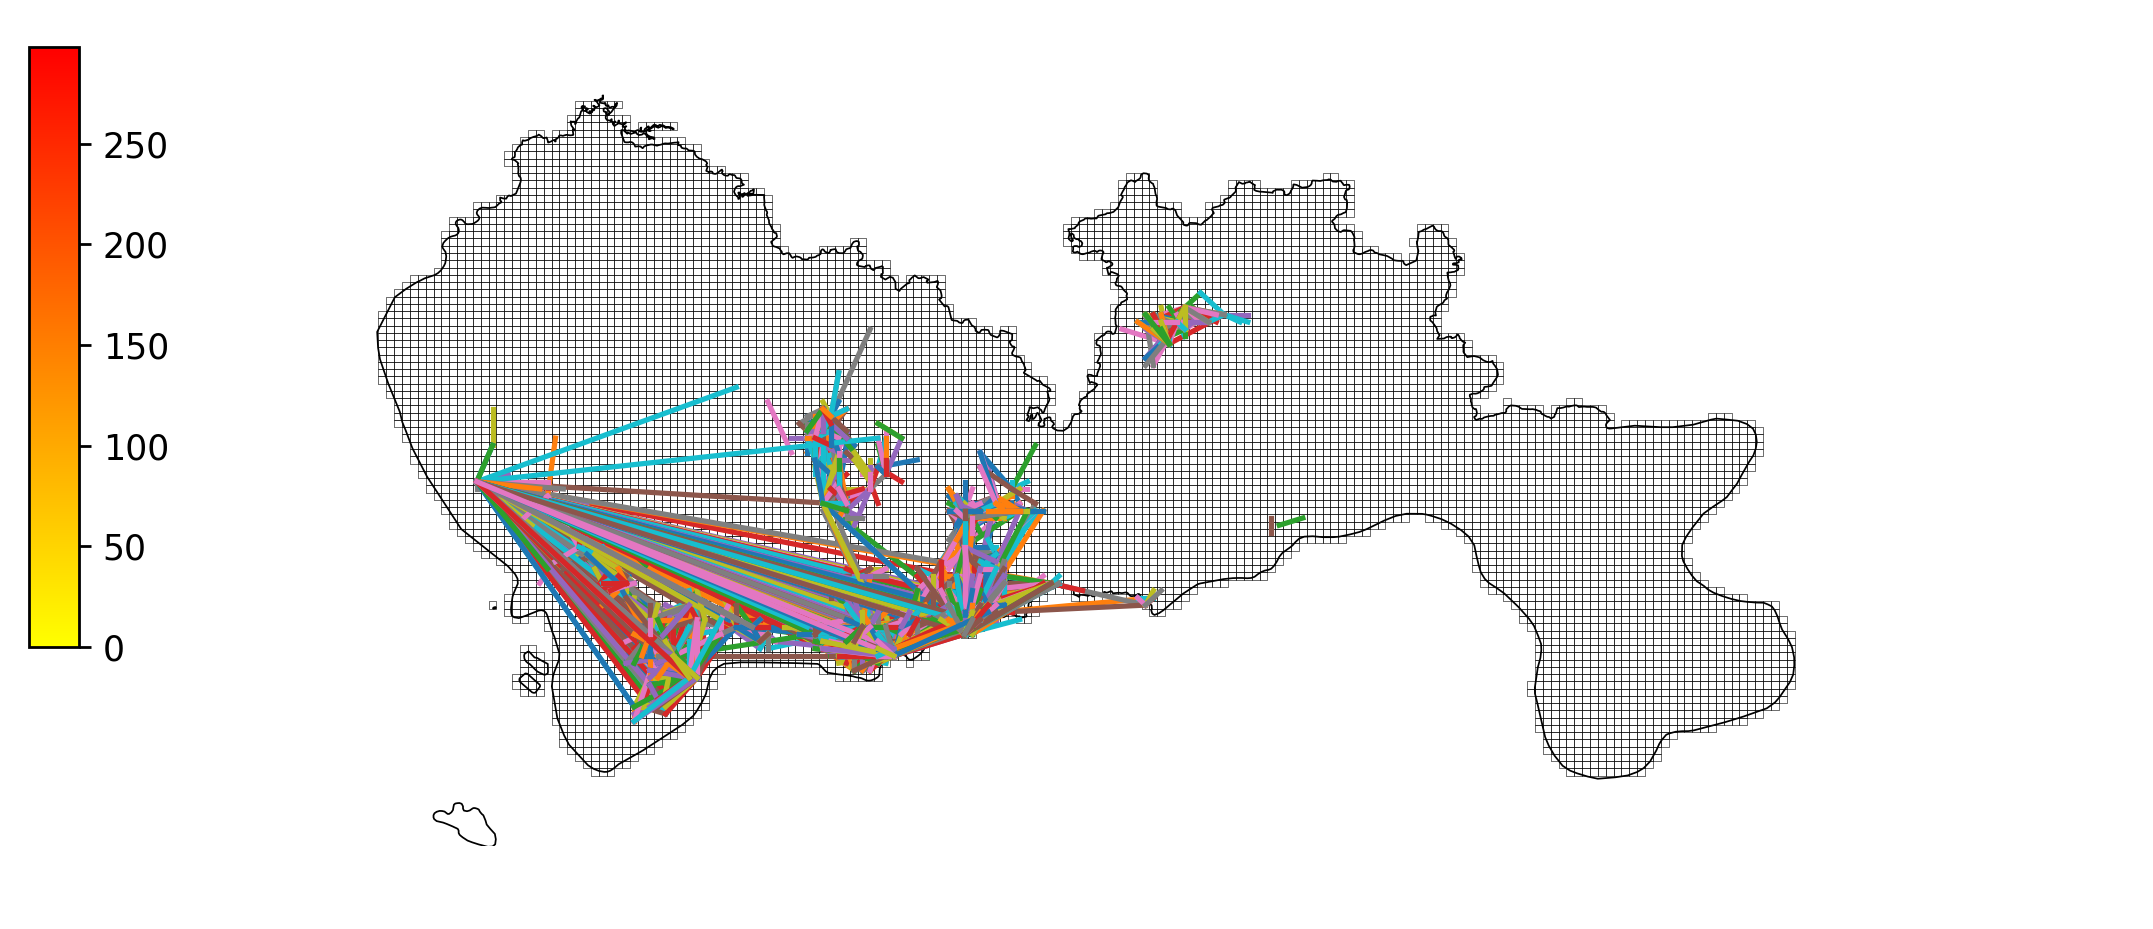

In [28]:
import time

fig = plt.figure(1,(10,8),dpi = 250)    
ax = plt.subplot(111)
plt.sca(ax)

#把刚才生成的栅格在ax上绘制
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#绘制整个深圳的范围
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#设定colormap的颜色
cmapname = 'autumn_r'
#cmap是一个获取颜色的工具，cmap(a)会返回颜色，其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)

#绘制OD
timeflag = time.time()
for i in range(len(OD1)):
    #设定plt.plot里面的参数alpha和color和linewidth
    plt.plot([OD1['SHBLON'].iloc[i],OD1['EHBLON'].iloc[i]], [OD1['SHBLAT'].iloc[i],OD1['EHBLAT'].iloc[i]])
    
print('绘制OD用时',time.time()-timeflag,'秒')
    
#不显示坐标轴
plt.axis('off')    

#绘制假的colorbar，这是因为，我们画的OD是线，没办法直接画出来colorbar
#所以我们在一个看不见的地方画了一个叫imshow的东西，他的范围是0到vmax
#然后我们再对imshow添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

#然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了


ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)



plt.show()

### 6.更快的绘制方法
如果遍历绘制OD，绘制速度比较慢，绘制5319条OD用时31s。
但是，如果把DataFrame变成GeoDataFrame，然后用自带的plot函数绘制，会快很多

In [21]:
#把DataFrame变成GeoDataFrame
#对每一行生成线的geometry

from shapely.geometry import LineString
OD1['geometry'] = OD1.apply(lambda r:LineString([[r['SHBLON'],r['SHBLAT']],[r['EHBLON'],r['EHBLAT']]]),axis = 1)
OD1 = geopandas.GeoDataFrame(OD1)

OD1.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,SHBLON,SHBLAT,EHBLON,EHBLAT,linewidth,geometry
41465,37,17,34,21,11,113.929790,22.522031,113.915173,22.540017,0.1,"LINESTRING (113.92979 22.52203, 113.91517 22.5..."
93970,59,27,61,20,11,114.036988,22.566997,114.046733,22.535521,0.1,"LINESTRING (114.03699 22.56700, 114.04673 22.5..."
149728,74,20,76,27,11,114.110077,22.535521,114.119822,22.566997,0.1,"LINESTRING (114.11008 22.53552, 114.11982 22.5..."
38433,36,18,37,18,11,113.924918,22.526528,113.929790,22.526528,0.1,"LINESTRING (113.92492 22.52653, 113.92979 22.5..."
138355,71,23,68,23,11,114.095459,22.549011,114.080841,22.549011,0.1,"LINESTRING (114.09546 22.54901, 114.08084 22.5..."


绘制底图用时 1.7341785430908203 秒
绘制OD用时 0.2667062282562256 秒


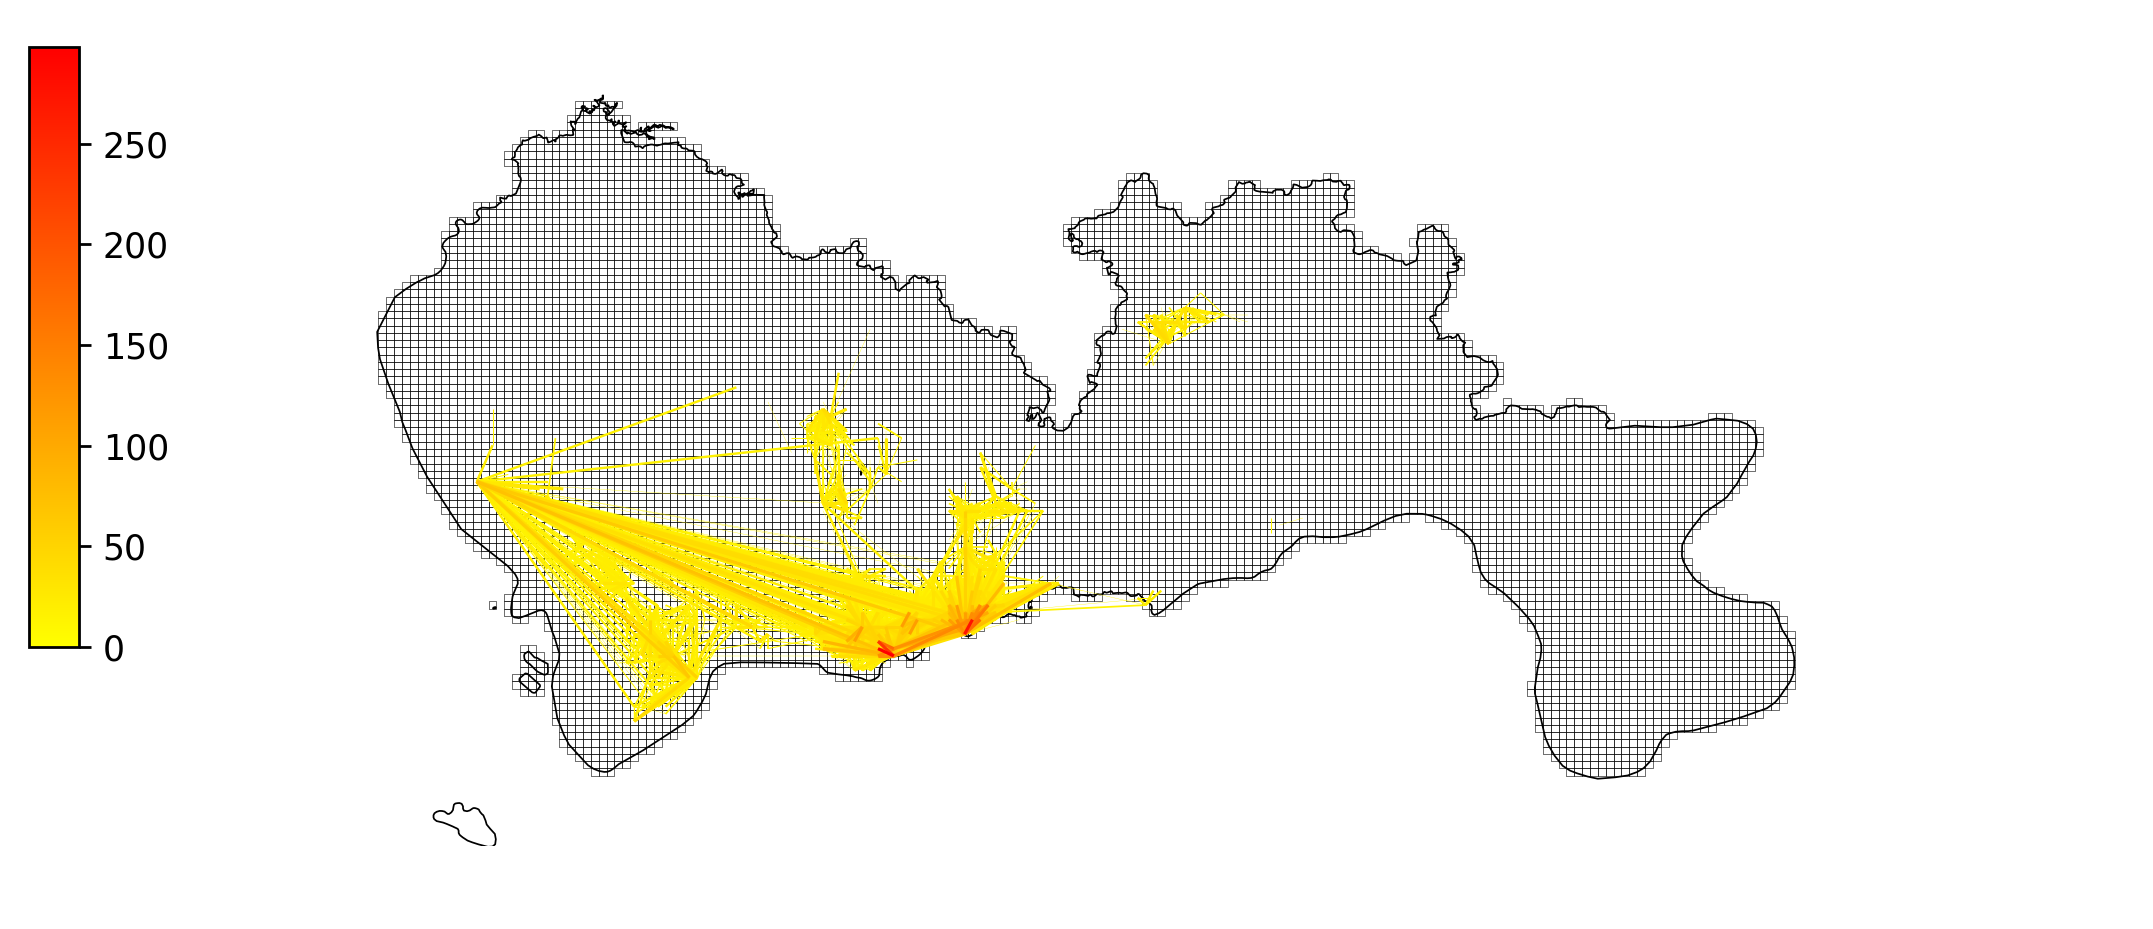

In [22]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#计时
import time
timeflag = time.time()
#绘制底图
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)
print('绘制底图用时',time.time()-timeflag,'秒')


#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)

timeflag = time.time()
#绘制OD
OD1.plot(ax = ax,column = 'VehicleNum',vmax = vmax,vmin = 0,cmap = cmap,linewidth = OD1['linewidth'])
print('绘制OD用时',time.time()-timeflag,'秒')

plt.axis('off')    
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)
plt.show()